In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import numpy as np
import imp
from mpl_toolkits.basemap import Basemap

sn.set_context('talk')

# Figures for draft 1 of the ECOREG paper

Converting results from earlier analyses to greyscale and tidying up a bit.

In [2]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)
hi_df = hi_df.query('(eco_dataset=="pb") & (time_per==3)') # Just the 3 year dataset

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

In [3]:
# Added 27/07/2017
# Daniel recommends removing German site 107002711
# from the analysis (see e-mail from Susi received 30/05/2017 at 11.20)
hi_df = hi_df[hi_df.index != 107002711]
site_df = site_df[site_df.index != 107002711]
mzb_df = mzb_df[mzb_df.index != 107002711]
pb_df = pb_df[pb_df.index != 107002711]

## Fig. 1: Site map

C:\Data\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Data\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


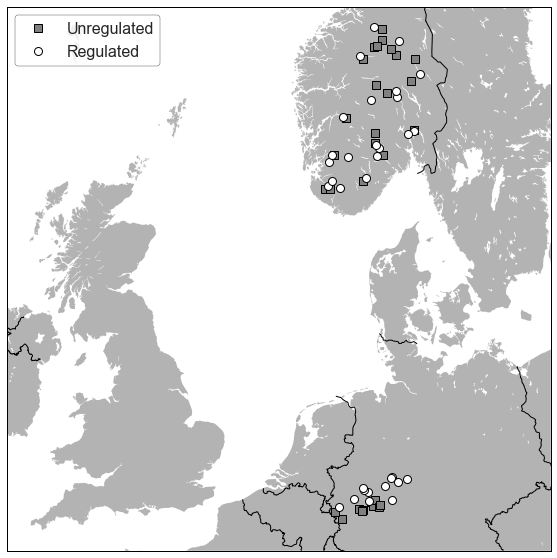

In [4]:
# Map
# Map of sites
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=1500000,
            height=1500000,
            resolution='h',
            lat_1=46.5,          # 1st standard parallel
            lat_2=66.5,          # 2st standard parallel
            lon_0=4,lat_0=56.5)  # Central point

# Add map components
m.fillcontinents (color='0.7', lake_color='white')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='white')

# Map (long, lat) to (x, y) for plotting
x, y = m(site_df['lon'].values, site_df['lat'].values)

# Add to df
site_df['east'] = x
site_df['north'] = y

# Get reg and unreg
reg_df = site_df.query('regulated == 1')
ureg_df = site_df.query('regulated == 0')

# Plot
plt.plot(ureg_df['east'], ureg_df['north'], 'sk', 
         mfc='0.5', mec='k', mew=1, 
         markersize=8, label='Unregulated')

plt.plot(reg_df['east'], reg_df['north'], 'ok', 
         mfc='white', mec='k', mew=1, 
         markersize=8, label='Regulated')

#plt.title('ECOREG site locations', fontsize=18)
l = plt.legend(loc='upper left', fontsize=16, 
               frameon=True, fancybox=True)
l.get_frame().set_facecolor('white')
l.get_frame().set_edgecolor('k')

# Save
out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\site_map.png'
plt.savefig(out_path, dpi=300)

## Fig. 2: Hydrological regimes

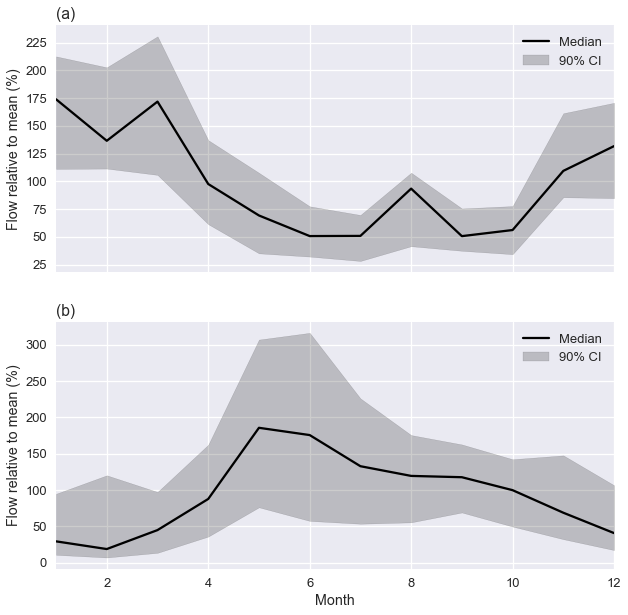

In [5]:
# Extract data of interest
df = hi_df.query('(eco_dataset=="pb") & (time_per==3)')

# Extract cols of interest
cols = ['avg%02d' % mon for mon in range(1, 13)] + ['mean',]
df = df[cols]

# Calculate monthly as % of long-term mean
for col in df.columns:
    df[col] = 100.* df[col] / df['mean']

del df['mean']
    
# Join country 
df = df.join(site_df['country'])

# Calc ststs.
grpd = df.groupby('country')
df = grpd.describe(percentiles=[0.05, 0.50, 0.95])

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, 
                         sharex=True, figsize=(10, 10))

# Germany
axes[0].fill_between(range(1, 13), 
                     df.loc['D', '5%'].values,
                     df.loc['D', '95%'].values,
                     color='k', alpha=0.2, 
                     label='90% CI')
axes[0].plot(range(1, 13), 
             df.loc['D', '50%'].values,
             'k-', label='Median')

axes[0].set_ylabel('Flow relative to mean (%)')
axes[0].set_title('(a)', loc='left')
axes[0].legend(loc='best')

# Norway
axes[1].fill_between(range(1, 13), 
                     df.loc['N', '5%'].values,
                     df.loc['N', '95%'].values,
                     color='k', alpha=0.2, 
                     label='90% CI')
axes[1].plot(range(1, 13), 
             df.loc['N', '50%'].values,
             'k-', label='Median')

axes[1].set_ylabel('Flow relative to mean (%)')
axes[1].set_title('(b)', loc='left')
axes[1].legend(loc='best')

plt.xlim((1, 12))
plt.xlabel('Month')

# Save
out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\flow_regimes.png'
plt.savefig(out_path, dpi=300)

## Fig. 4: PCA example

In [6]:
def run_pca(df, cols=None, out_png=None):
    """ Applies PCA and generates summary plots.
    
    Args:
        df      Dataframe of features. Must include "country" and "regulated" 
                columns
        cols    Subset of columns to use
        
    Returns:
        Dataframe of PC loadings. Also generates a range of plots.
    """  
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import mpld3

    # Define and markers to use for different categories
    groups_dict = {(u'D', 0):('Unregulated', 'k', 'o'),
                   (u'N', 0):('Unregulated', 'k', 'o'),
                   (u'D', 1):('Regulated', 'k', '^'),
                   (u'N', 1):('Regulated', 'k', '^')}
    
    # Extract cols of interest
    cats = df[['country', 'regulated']]

    if cols:
        df = df[cols].astype(float)

    # Standardise the feature data
    feat_std = StandardScaler().fit_transform(df)

    # Setup PCA. Initially, choose to keep ALL components
    pca = PCA()

    # Fit model
    pca.fit(feat_std)

    # Get explained variances (in %)
    var_exp = 100*pca.explained_variance_ratio_
    cum_exp = np.cumsum(var_exp)

    # Get eigenvalues
    cov_mat = np.cov(feat_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Get number of EVs > 1 (Kaiser-Guttman criterion)
    # and print summary
    n_kgc = (eig_vals > 1).sum()
    print 'Variance explained by first %s PCs (%%):\n' % n_kgc
    print var_exp[:n_kgc]
    print '\nTotal: %.2f%%' % var_exp[:n_kgc].sum()
    
    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
      
    # Eigenvalues
    axes[0].plot(range(1, len(eig_vals)+1), np.sort(eig_vals)[::-1], 
                 'k-o', label='Eigenvalues')
    axes[0].axhline(1, c='k', ls='--', label='Kaiser-Guttman threshold')
    axes[0].set_xlabel('Principal component')
    axes[0].set_ylabel('Eigenvalue')
    axes[0].legend(loc='upper right') 
    axes[0].set_title('(a)', loc='left', fontsize=20)
    
    # PC loadings
    loads = pd.DataFrame(data=pca.components_, 
                         columns=df.columns,
                         index=range(1, pca.components_.shape[0]+1)).T
   
    # Refit the PCA, this time specifying 2 components
    # and transforming the result
    feat_reduced = PCA(n_components=2).fit_transform(feat_std)
    
    # Build df 
    data = pd.DataFrame({'PC1':feat_reduced[:, 0],
                         'PC2':feat_reduced[:, 1],
                         'country':cats['country'],
                         'regulated':cats['regulated']})    

    groups = data.groupby(['country', 'regulated'])
    
    # Plot
    for name, group in groups:
        axes[1].scatter(group['PC1'], group['PC2'], s=100, lw=1,
                        label=groups_dict[name][0],
                        marker=groups_dict[name][2],
                        facecolors='white', 
                        edgecolors='k')
        
    axes[1].set_xlabel('First principal component')
    axes[1].set_ylabel('Second principal component')
    axes[1].set_title('(b)', loc='left', fontsize=20)
    l = axes[1].legend(loc='lower right', frameon=True)
    l.get_frame().set_edgecolor('k')
    
    if out_png:
        plt.savefig(out_png, dpi=300)
    
    plt.tight_layout()
    plt.show()

    return loads

Variance explained by first 3 PCs (%):

[ 47.15103586  20.57610931  15.01732106]

Total: 82.74%


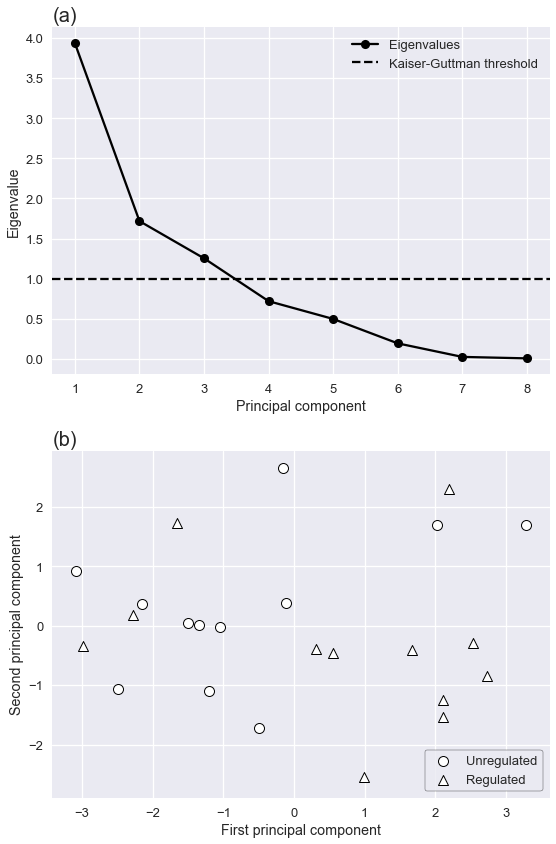

,1,2,3,4,5,6,7,8
pb_rich,0.470834,-0.052387,0.167972,-0.371005,0.212707,-0.037973,-0.555186,0.504772
green_rich,0.208074,-0.601117,0.298898,-0.349261,0.233626,0.332528,0.393047,-0.253769
cyano_rich,0.414141,0.308274,-0.188102,-0.306034,0.219224,-0.589740,0.241834,-0.387400
red_rich,0.307929,0.263295,0.434615,-0.153380,-0.769717,0.112540,0.055484,-0.123415
pb_abund,0.450090,-0.141856,-0.187604,0.457102,0.019783,0.230982,-0.452128,-0.524399
green_abund,0.240947,-0.588825,-0.208872,0.262196,-0.378526,-0.470102,0.177115,0.295308
cyano_abund,0.335303,0.212500,-0.608242,-0.082205,-0.069554,0.503153,0.344949,0.297840
red_abund,0.309229,0.244054,0.457593,0.582017,0.333375,-0.003660,0.347766,0.254139


In [7]:
# Join categorical variables to PB data
df = pb_df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_rich', 'red_rich', 
           'pb_abund', 'green_abund', 'cyano_abund', 'red_abund']

# Run PCA
out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\pca_ger_pb.png'
res = run_pca(df, cols=pb_cols, out_png=out_path)
res

## Fig. 5: PPC example

In [8]:
def bayesian_t(df, val_col, grp_col='regulated',
               sig_fac=2, unif_l=0, unif_u=20,
               exp_mn=30, 
               plot_trace=False, plot_ppc=False,
               plot_vars=False, plot_diffs=True,
               steps=2000, mcmc='metropolis'):
    """ Simple Bayesian test for differences between two groups.
    
    Args:
        df         Dataframe. Must have a column containing values
                   and a categorical 'regulated' column that is [0, 1]
                   to define the two groups
        val_col    Name of the values column
        grp_col    Name of the categorical column defining the groups
        sig_fac    Factor applied to std. dev. of pooled data to define
                   prior std. dev. for group means
        unif_l     Lower bound for uniform prior on std. dev. of group
                   means
        unif_u     Upper bound for uniform prior on std. dev. of group
                   means
        exp_mn     Mean of exponential prior for v in Student-T 
                   distribution
        plot_trace Whether to plot the MCMC traces
        plot_ppc   Whether to perform and plot the Posterior Predictive
                   Check 
        plot_vars  Whether to plot posteriors for variables
        plot_diffs Whether to plot posteriors for differences
        steps      Number of steps to take in MCMC chains
        mcmc       Sampler to use: ['metropolis', 'slice', 'nuts']
    
    Returns:
        Creates plots showing the distribution of differences in 
        means and variances, plus optional diagnostics. Returns the 
        MCMC trace
    """
    import numpy as np
    import pymc3 as pm
    import pandas as pd
    import seaborn as sn
    import matplotlib.pyplot as plt

    # Get overall means and s.d.
    mean_all = df[val_col].mean()
    std_all = df[val_col].std()

    # Group data
    grpd = df.groupby(grp_col)
    
    # Separate groups
    reg_data = grpd.get_group(1)[val_col].values
    ureg_data = grpd.get_group(0)[val_col].values   

    # Setup model
    with pm.Model() as model:
        # Priors for means of Student-T dists
        reg_mean = pm.Normal('regulated_mean', mu=mean_all, sd=std_all*sig_fac)
        ureg_mean = pm.Normal('unregulated_mean', mu=mean_all, sd=std_all*sig_fac)

        # Priors for std. dev. of Student-T dists
        reg_std = pm.Uniform('regulated_std', lower=unif_l, upper=unif_u)
        ureg_std = pm.Uniform('unregulated_std', lower=unif_l, upper=unif_u)

        # Prior for v of Student-T dists
        nu = pm.Exponential('v_minus_one', 1./29.) + 1

        # Define Student-T dists
        # PyMC3 uses precision = 1 / (sd^2) to define dists rather than std. dev.
        reg_lam = reg_std**-2
        ureg_lam = ureg_std**-2

        reg = pm.StudentT('regulated', nu=nu, mu=reg_mean, lam=reg_lam, observed=reg_data)
        ureg = pm.StudentT('unregulated', nu=nu, mu=ureg_mean, lam=ureg_lam, observed=ureg_data)

        # Quantities of interest (difference of means and std. devs.)
        diff_of_means = pm.Deterministic('difference_of_means', reg_mean - ureg_mean)
        diff_of_stds = pm.Deterministic('difference_of_stds', reg_std - ureg_std)
        
        # Run sampler to approximate posterior
        if mcmc == 'metropolis':
            trace = pm.sample(steps, step=pm.Metropolis())
        elif mcmc == 'slice':
            trace = pm.sample(steps, step=pm.Slice())
        elif mcmc == 'nuts':
            trace = pm.sample(steps)
        else:
            raise ValueError("mcmc must be one of ['metropolis', 'slice', 'nuts']")

    # Plot results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
        
    # Posteriors for differences
    pm.plot_posterior(trace[1000:],
                      varnames=['difference_of_means', 'difference_of_stds'],
                      ref_val=0,
                      alpha=0.3,
                      ax=axes[0])
    
    # Clear centre titles and set left titles
    axes[0,0].set_title('')
    axes[0,0].set_title('(a)', loc='left')
    axes[0,1].set_title('')
    axes[0,1].set_title('(b)', loc='left')
    axes[0,0].set_ylabel('Frequency')
    axes[0,1].set_ylabel('Frequency')
    axes[0,0].set_xlabel('Difference of means')
    axes[0,1].set_xlabel('Difference of standard deviations')
    
    # Posterior predictive check
    ppc = pm.sample_ppc(trace, samples=500, model=model, size=100)

    sn.distplot([n.mean() for n in ppc['unregulated']], 
                ax=axes[1,0])
    axes[1,0].axvline(ureg_data.mean(), c='k')
    axes[1,0].set_title('(c)', loc='left')
    axes[1,0].set(xlabel='Mean', 
                  ylabel='Frequency',
                  xlim=(0.5, 2))
    axes[1,0].set_yticklabels([])

    sn.distplot([n.mean() for n in ppc['regulated']], 
                ax=axes[1,1])
    axes[1,1].axvline(reg_data.mean(), c='k')
    axes[1,1].set_title('(d)', loc='left')
    axes[1,1].set(xlabel='Mean', 
                  ylabel='Frequency',
                  xlim=(0.5, 2))
    axes[1,1].set_yticklabels([])
    
    fig.tight_layout()

    out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\diffs_nor_cv.png'
    plt.savefig(out_path, dpi=300)
    
    return trace

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 71.20it/s]


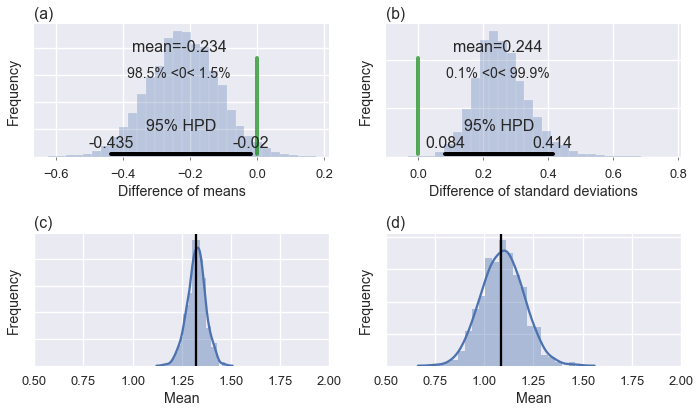

In [9]:
# Columns to consider
hi_cols = ['mean', 'p50', 'cv', 'revs_per_yr',
           'n_hi_pulse_yr', 'av_fall_rt', 'av_rise_rt']

# Get PB data
df = hi_df[hi_cols]

# Join categorical variables to MZB data
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "N"')

# Run MCMC
trace = bayesian_t(df, 'cv', 
                   plot_trace=False, plot_ppc=True,
                   plot_vars=False, plot_diffs=True,
                   steps=10000, mcmc='slice')

## Fig. 6: Lasso path

In [10]:
def plot_lasso_path(df, resp_var, exp_vars):
    """ Plot the lasso path. Both response and explanatory
        variables are standardised first.
    
    Args:
        df:       Dataframe
        resp_var: String. Response variable
        exp_vars: List of strings. Explanatory variables
    
    Returns:
        Dataframe of path and matplotlib figure with tooltip-
        labelled lines. To view this figure in a notebook, use
        mpld3.display(f) on the returned figure object, f.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import mpld3
    from mpld3 import plugins
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import lasso_path

    # Standardise the feature data and response
    feat_std = StandardScaler().fit_transform(df[[resp_var,] + exp_vars])
    
    # Calculate lasso path
    alphas, coefs, _ = lasso_path(feat_std[:, 1:],         # X
                                  feat_std[:, 0],          # y
                                  eps=1e-3,                # Path length
                                  fit_intercept=False)     # Already centred

    # -Log(alphas) is easier for display
    neg_log_alphas = -np.log10(alphas)

    # Build df of results
    res_df = pd.DataFrame(data=coefs.T, index=alphas, columns=exp_vars)
    
    # Plot
    fig, ax = plt.subplots()

    for coef, name in zip(coefs, exp_vars):
        line = ax.plot(neg_log_alphas, coef, label=name)
        plugins.connect(fig, plugins.LineLabelTooltip(line[0], label=name))

    plt.xlabel(r'-Log($\alpha$)')
    plt.ylabel('Standardised coefficients')
    plt.xlim((0,4))
    #plt.title('Lasso paths')
    #plt.legend(loc='best', title='', ncol=3)  
    out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\lasso_path.png'
    plt.savefig(out_path, dpi=300)
    
    return res_df, fig

In [11]:
cols = ['swim_div', 'cond', 'tn', 'toc', 'mean', 'cv', 'n_hi_pulse_yr', 
        'revs_per_yr', 'range', 'max10', 'max12', 'country']
df = pd.concat([site_df, mzb_df, hi_df], axis=1)[cols]
df = df.query('country == "D"')
df.dropna(how='any', inplace=True)

# Lists of explan and resp vars
exp_vars = ['cond', 'tn', 'toc', 'mean', 'cv', 'n_hi_pulse_yr', 
            'revs_per_yr', 'range', 'max10', 'max12']
resp_var = 'swim_div'

# Plot lasso path
res_df, fig = plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

## Fig. 7: Best lasso

In [12]:
def best_lasso(df, resp_var, exp_vars, kcv=3, cv_path=False, 
               hists=False):
    """ Find the best lasso model through cross-validation.
    
    Args:
        df:       Dataframe
        resp_var: String. Response variable
        exp_vars: List of strings. Explanatory variables
        kcv:      Number of cross-validation folds
        cv_path:  Whether to plot the path of cross-validation
                  scores
        hists:    Whether to plot histograms of coefficient
                  estimates based on bootstrapping
    
    Returns:
        Dataframe of coefficients for best model and histograms
        of coefficient variability based on bootstrap resampling.
    """
    import seaborn as sn
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LassoCV
    from sklearn.utils import resample

    # Standardise the feature data and response
    feat_std = StandardScaler().fit_transform(df[[resp_var,] + exp_vars])

    model = LassoCV(fit_intercept=False, 
                    normalize=False, 
                    max_iter=10000,
                    cv=kcv,
                    eps=1e-3)

    # Train model on full dataset
    model.fit(feat_std[:, 1:], feat_std[:, 0])

    print model

    # Get param estimates
    params = pd.DataFrame(pd.Series(model.coef_, index=exp_vars))
    
    if cv_path:
        # Display results
        m_log_alphas = -np.log10(model.alphas_)

        plt.figure()
        #plt.plot(m_log_alphas, model.mse_path_, ':')
        plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
                 label='Average cross-validation score', linewidth=2)
        plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
                    label=r'Optimum $\alpha$')
        plt.legend(loc='lower right')

        plt.xlabel(r'-Log($\alpha$)')
        plt.ylabel('Mean squared error')
        plt.axis('tight')
        plt.ylim(ymin=0.8)
        
        out_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Paper\Drafts\figures\best_lasso.png'
        plt.savefig(out_path, dpi=300)
        
        plt.show()

    if hists:
        # Estimate confidence using bootstrap
        # i.e. what is the std. dev. of the estimates for each parameter
        # based on 1000 resamplings
        err = np.array([model.fit(*resample(feat_std[:, 1:], 
                                            feat_std[:, 0])).coef_ for i in range(1000)])
        err_df = pd.DataFrame(data=err, columns=exp_vars)

        # Melt for plotting with seaborn
        err_df = pd.melt(err_df)
        g = sn.FacetGrid(err_df, col="variable", col_wrap=4)
        g = g.map(plt.hist, "value", bins=20)

        # Vertical line at 0
        g.map(sn.plt.axvline, x=0, c='k', lw=2)
  
    return params

LassoCV(alphas=None, copy_X=True, cv=4, eps=0.001, fit_intercept=False,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


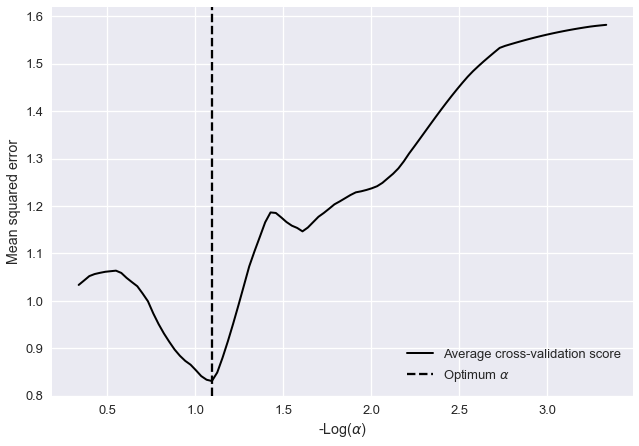

,0
cond,0.000000
tn,-0.018572
toc,-0.188953
mean,0.000000
cv,0.000000
n_hi_pulse_yr,0.334708
revs_per_yr,0.515279
range,0.000000
max10,-0.000000
max12,0.000000


In [13]:
# Lists of explan and resp vars
exp_vars = ['cond', 'tn', 'toc', 'mean', 'cv', 'n_hi_pulse_yr', 
            'revs_per_yr', 'range', 'max10', 'max12']
resp_var = 'swim_div'

params = best_lasso(df, resp_var, exp_vars, kcv=4, cv_path=True, hists=False)
params